# Rational
<center>Development for a fitting function (greedy+linear based on mvpolyfit and gmvpfit) that handles rational fucntions</center>

In [1]:
# Low-level import 
from numpy import *
from numpy.linalg import pinv,lstsq
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup plotting backend
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import *
#
import positive
from positive import *

## Formalism: An algorithm to model rational functions in the pseudo-linear sense

1. Given $\psi$, and $\vec{x}$, such that 

$$  
\begin{align}
    \psi &= A(\vec{x}) / B(\vec{x}) \text{, where}
    \\
    A(\vec{x}) &= \sum_{j=0}^M ~ a_j \mu^{j}(\vec{x})  
    \\
    B(\vec{x}) &= \sum_{k=0}^N ~ b_k \nu^{k}(\vec{x}) 
    \\ \nonumber
               &= 1 + \sum_{k=1}^{N} ~ b_k \nu^{k}(\vec{x})
\end{align}
$$

2. We care to consider the following to be known and unknown:

 * **Known**: $\psi$, $\vec{x}$, $b_0=1$
 * **Unknown**: $\mu^j$, $\nu^k$
 
3. We seek to write this as a normal linear equation.These manipulations follow:

    $$
    \begin{align}
        &\rightarrow \psi B(\vec{x}) = A(\vec{x})
        \\ \nonumber
        &\rightarrow \psi + \sum_{k=1}^{N} ~ \psi b_k \nu^{k}(\vec{x}) = \sum_{j=0}^M ~ a_j \mu^{j}(\vec{x}) 
        \\ \nonumber
        &\rightarrow \psi = \sum_{j=0}^M ~ a_j \mu^{j}(\vec{x}) - \sum_{k=1}^{N} ~ \psi b_k \nu^{k}(\vec{x})
    \end{align}
    $$

4. We will consider $\psi$ and $\vec{x}$ to be descritized: $\psi_i$ and $\vec{x}_i$, with $0 \le i \le Q$. This gives

    $$
    \begin{align}
        \psi_i = \sum_{j=0}^M ~ a_j \mu^{j}(\vec{x}_i) - \sum_{k=1}^{N} ~ \psi_i b_k \nu^{k}(\vec{x}_i)
    \end{align}
    $$

5. Then, we note that the last line, upon a concatenation of the indeces, may be considered as a matrix operating on a vector. For simplicity we will write this matriv and vector notation.

    $$
    \begin{align}
        \vec{\psi} = \hat{\alpha} \vec{c}
    \end{align}
    $$

    with

    $$
    \begin{align}
        \vec{c} = (c_0,c_1,...c_k,c_k+1,...c_{M+N})
        \\ \nonumber
        c_k = \left\{\begin{array}{ll}
            a_k, & \text{for } 0\leq k \leq M\\
            b_{k-M}, & \text{for } M < k \leq M+N
            \end{array}\right\}
    \end{align}
    $$

    and

    $$
    \begin{align}
        \hat{\alpha} \text{ is of shape } Q \times (M+N+1) \text{, and has elements } \alpha^{k}(\vec{x}_j)
        \\ \nonumber
        \alpha^{k}(\vec{x}_j) = \left\{\begin{array}{ll}
            \mu^k(\vec{x}_j), & \text{for } 0\leq k \leq M\\
            -\psi_j \nu^k(\vec{x}_j), & \text{for } M < k \leq M+N
            \end{array}\right\}
    \end{align}
    $$
    
5. With this, $\vec{c}$ (the vector of fit coefficients) is determined via

    $$
        \vec{c} = \hat{\alpha}^{-1} \vec{\psi}
    $$

## Package Development (positive/learning.py)

(mvrfit)>> Centering ON. The input numerator symbols are ['K'], but ['00', '11', 'K'] will be used to accomodate centering.
(mvrfit)>> Approach: Psi = (1+A)/(1+B)
['00', '11']
['00', '11']
[-0.19820738 -0.19813879]
[ 0.05977118  0.05966895]
0.0216816602305


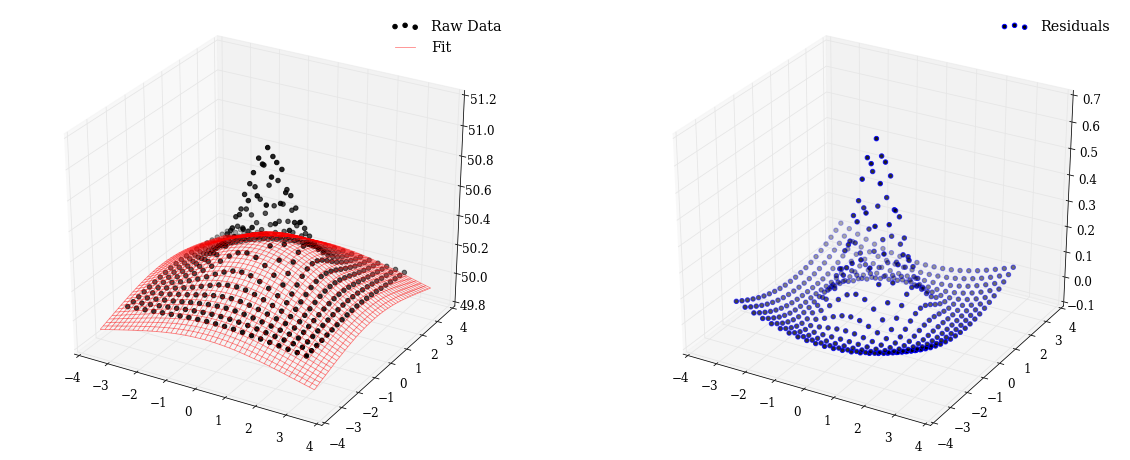

In [10]:
################################################################################
h = 3
Q = 21
x = h*linspace(-1,1,Q)
y = h*linspace(-1,1,Q)
X,Y = meshgrid(x,y)
zfun = lambda xx,yy: 50 + 1.0 / ( 1.0 + xx**2 + yy**2 )
np.random.seed(42)
Z = zfun(X,Y) + 0.0005*(np.random.random( X.shape )-0.5)
basis_symbols = ( ['K'], ['00','11'] ) # ( [Numerator], [Denominator without constant term] )
domain,scalar_range = ndflatten( [X,Y], Z )
################################################################################

# Solver for rational functions in the same form as those for polynomials
def mvrfit( domain, scalar_range, numerator_symbols, denominator_symbols, centering=True, verbose=True, method=0 ):
    '''
    '''
    
    #
    from numpy import mean,std

    # Shorthand
    mu = mean(scalar_range) if centering else 0
    sigma = std(scalar_range) if centering else 1.0
    centered_scalar_range = (scalar_range - mu) / sigma 
    denominator_symbols = sorted( list(denominator_symbols) )
    __numerator_symbols__ = numerator_symbols
    numerator_symbols = sorted(list( set( list(numerator_symbols) + denominator_symbols ) ) if centering else list(numerator_symbols))
    
    #
    if verbose:
        if centering:
            alert('Centering ON. The input numerator symbols are %s, but %s will be used to accomodate centering.'%( yellow(str(__numerator_symbols__)), yellow(str(numerator_symbols)) ) )
        else:
            warning('Centering is OFF. This will result in inaccurate results IF the data has a non-zero constant offset.')

    #
    if method in [0]:
        alert('Approach: Psi = A/(1+B)')
        numerator_coeffs, denominator_coeffs, fitfun = mvrslv0( domain, centered_scalar_range, numerator_symbols, denominator_symbols, mu=mu, sigma=sigma )
    elif method in [1]:
        alert('Approach: Psi = (1+A)/(1+B)')
        _numerator_symbols = [s for s in numerator_symbols if s!='K']
        numerator_coeffs, denominator_coeffs, fitfun = mvrslv1( domain, centered_scalar_range, _numerator_symbols, denominator_symbols, mu=mu, sigma=sigma )
    else:
        error('Unknown solver method given.')
    
    #
    residuals = scalar_range - fitfun( domain )
    
    #
    fit_info = { 'numerator_coeffs':numerator_coeffs,
                 'denominator_coeffs':denominator_coeffs,
                 'residuals':residuals,
                 'fitfun':fitfun
               }
    
    #
    return fit_info
    


################################################################################
fit_info = mvrfit(domain, scalar_range, basis_symbols[0], basis_symbols[1], method=1 )
print fit_info['numerator_coeffs']
print fit_info['denominator_coeffs']
print mean(fit_info['residuals'])
################################################################################


#
fig = figure( figsize=2*array([10,4]) )
ax = fig.add_subplot(121,projection='3d')

# Plot the raw data points
ax.scatter( domain[:,0], domain[:,1], scalar_range, marker='o', color='k',zorder=1, facecolors='k',label='Raw Data')

# Setup grid points for model
padf = 0.1
dx = ( max(domain[:,0])-min(domain[:,0]) ) * padf
dy = ( max(domain[:,1])-min(domain[:,1]) ) * padf
fitx = linspace( min(domain[:,0])-dx, max(domain[:,0])+dx, 45 )
fity = linspace( min(domain[:,1])-dy, max(domain[:,1])+dy, 45 )
xx,yy = meshgrid( fitx, fity )
fitdomain,_ = ndflatten( [xx,yy], yy )
# Plot model on grid
zz = fit_info['fitfun']( fitdomain ).reshape( xx.shape )
ax.plot_wireframe(xx, yy, zz, color='r', rstride=1, cstride=1,zorder=1,alpha=0.5,label='Fit')

legend(frameon=False)

ax = fig.add_subplot(122,projection='3d')
ax.scatter( domain[:,0], domain[:,1], fit_info['residuals'].reshape( domain[:,0].shape ), marker='o', color='b',zorder=1, facecolors='k',label='Residuals')
legend(frameon=False)